In this project, we aim to measure the risk exposure of a portfolio using historical simulation with some adjustments.  
we use a hedged portfolio consisting of a binary option on the .SPX and a call spread.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import skew,kurtosis


first we try to import the sp500 index historical data and have a glance.

In [3]:
sp500=pd.read_excel('Price History_20220423_1700.xlsx',header=0,parse_dates=True,index_col=0)
sp500.head()

,Close,Net,%Chg,Open,Low,High
Exchange Date,,,,,,
2022-04-22,4271.78,-121.88,-0.027740,4383.09,4268.01,4384.17
2022-04-21,4393.66,-65.79,-0.014753,4495.94,4384.99,4512.41
2022-04-20,4459.45,-2.76,-0.000619,4462.21,4449.03,4487.10
2022-04-19,4462.21,70.52,0.016058,4390.63,4390.63,4471.03
2022-04-18,4391.69,-0.90,-0.000205,4384.52,4370.48,4410.29


next we try to calculate portfolio spot price based on the latest historical data. the spot prices are the binary option price and call spread price.       
the call spread price consists of two call options with different strike prices, in order to hedge the binary option, we define the strikes of the two call option to be with $1 difference.      
Since we use the call spread to hedge the binary option, the portfolio value is the value of binary option minus the call spread value, we base on this consideration to calculate the portfolio value.

In [5]:
sigma=sp500['%Chg'].std()   # standard deviation of one-day interval
sigma=sigma*np.sqrt(252)    # standard deviation of one-year interval
r=0.05                      # assume the risk-free rate is 5% per year
S0=4271.78                  # spot price of SP500
K1=0.8*S0                   # assume the strike is 80% of the spot price 
K2=K1+1                     # another strike for the purpose of hedging
T=1                         # maturity of the options

# next calculate parameters based on BSM equations
# d1 and d2 for the first call option with K1 strike
d2_1=(np.log(S0/K1)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T)) 
d1_1=d2_1+sigma*np.sqrt(T)
# d1 and d2 for the second call option with K2 strike
d2_2=(np.log(S0/K2)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T))
d1_2=d2_2+sigma*np.sqrt(T)

# calculate prices of binary option and two call options
binary=np.exp(-r*T)*norm.cdf(d2_1)     
call1=S0*norm.cdf(d1_1)-K1*np.exp(-r*T)*norm.cdf(d2_1)
call2=S0*norm.cdf(d1_2)-K2*np.exp(-r*T)*norm.cdf(d2_2)
# portfolio value is just the difference of them, assuming 100000 shares
portfolio_spot=(binary-(call1-call2))*100000

In [6]:
print(sigma,d2_1)
print(binary,call1-call2,portfolio_spot)

0.1815843571456873 1.413431839441348
0.8763064146655176 0.8761937310273424 11.268363817518168


next to try to generate 500 scenarios from historical data, all based on the spot price of the sp500

In [7]:
sp500_hist=pd.DataFrame(sp500[['%Chg']],index=sp500.index)
sp500_hist.dropna(inplace=True)
sp500_hist=sp500_hist.iloc[-500:,:]
sp500_hist=sp500_hist[::-1]
sp500_hist.head()

,%Chg
Exchange Date,
2020-04-02,0.022829
2020-04-03,-0.015137
2020-04-06,0.070331
2020-04-07,-0.001603
2020-04-08,0.034056


we use the price of S&P 500 on the 2022.4.22, and generate 500 scenarios based on the historical data. On 2022.4.22, the S&P 500 price is 4271.78

In [8]:
sp500_spot=2470.50
scanario=sp500_spot*sp500_hist['%Chg']
sp500_hist['scanario']=scanario
sp500_hist['price_scene']=scanario+S0

In [9]:
sp500_hist.head()

,%Chg,scanario,price_scene
Exchange Date,,,
2020-04-02,0.022829,56.400000,4328.180000
2020-04-03,-0.015137,-37.396266,4234.383734
2020-04-06,0.070331,173.753487,4445.533487
2020-04-07,-0.001603,-3.960324,4267.819676
2020-04-08,0.034056,84.136401,4355.916401


we take a look at the 500 scenarios of sp500.

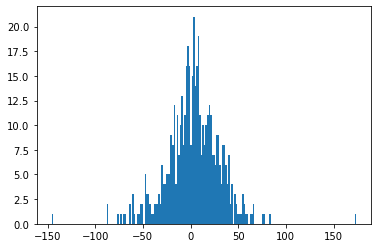

In [10]:
lgd=scanario.values
plt.hist(lgd,bins=200)
plt.show()

next to we try to calculate the portfolio change under these 500 scenarios, and lgd is the loss absolute value, meaning that if it is positive, then the portfolio is losing money and vice versa.

In [10]:
def portfolio_change(S0):
    '''
    calculate the portfolio change
    '''
    d2_1=(np.log(S0/K1)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T))
    d1_1=d2_1+sigma*np.sqrt(T)
    d2_2=(np.log(S0/K2)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T))
    d1_2=d2_2+sigma*np.sqrt(T)
    binary=np.exp(-r*T)*norm.cdf(d2_1)
    call1=S0*norm.cdf(d1_1)-K1*np.exp(-r*T)*norm.cdf(d2_1)
    call2=S0*norm.cdf(d1_2)-K2*np.exp(-r*T)*norm.cdf(d2_2)
    portfolio=(binary-(call1-call2))*100000
    return portfolio-portfolio_spot

lgd=[]
for i in sp500_hist['price_scene']:
    change=portfolio_change(i)
    lgd.append(-change)




so if we take the confidence level to be 99%, then VaR is the fifth data in the array, which is -72.92445604, and ES is (-145.62-87.17-86.77-75.78)/4.5-72.92 $\times$ 0.5/4.5=-96 and suppose we think that the loss is normally distributed, the precision is $\frac{1}{f(x)}\sqrt{\frac{(1-q)q}{n}}$ = 0.31   
then the var confidence interval is [-96-1.98 $\times$ 0.31, -96+1.98 $\times$ 0.31]


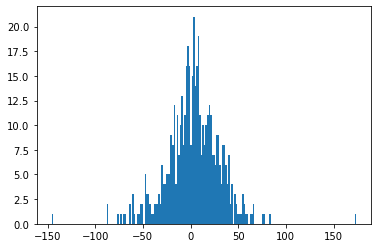

In [11]:
plt.hist(lgd,bins=200)
plt.show()

In [11]:
lgd.sort(reverse=True)
lgd[:25]

[3.2022229379480294,
 1.6423612474336657,
 1.5250775549202622,
 1.4822106125023105,
 1.3064560028031025,
 1.296640065062693,
 1.279204408433099,
 1.2551196924892594,
 1.1915633966741446,
 1.1652836085507268,
 1.1245844757312717,
 1.119806707161608,
 1.0986832720494277,
 1.098157067980221,
 1.0826960131438135,
 1.052339619689313,
 1.0189239951996498,
 0.9920966521193009,
 0.9610579603025471,
 0.9593448523137482,
 0.9354964678909283,
 0.9318321355422654,
 0.9201549762583028,
 0.8879663413008387,
 0.8796273890276929]

In [12]:
np.mean(lgd[:25])

1.2163562981011289

VaR is 0.8796 if we take confidence level to be 95%, and ES is the average of the first five data, which is 1.216.      
However, if we have a slight glance at the distribution of the loss, we can easily find that the loss is skewed to the left, which underestimate the VaR and ES, so in the next step, we will use a skewed distribution to estimate the VaR. Cornish-Fisher expansion is a good way to do that.     
Cornish-Fisher expansion is used to estimate the skewed quantile of the loss, we need to estimate the skewness and kortosis of the loss distribution.  


In [13]:
print(skew(lgd))
print(kurtosis(lgd))
print(np.mean(lgd))
print(np.std(lgd))
wq=norm.ppf(0.95)+1/6*(norm.ppf(0.95)**2-1)*skew(lgd)+1/24*(norm.ppf(0.95)**3-3*norm.ppf(0.95))*(kurtosis(lgd)-3)
print(np.mean(lgd)+wq*np.std(lgd))

-0.36621909307196926
3.8072732865343264
0.05570716732909986
0.5765661950001526
0.9346603182268327


cornish-fisher expansion gives the var to be 0.934. It is obviously larger than the estimate from historical scenarios.

next we try to estimate the var using extreme value theory.     
in order to calculate the var, we need to first estimate the parameter in the general pareto distribution.      
in EVT, using Hill estimator and we can get $ \xi = \frac{1}{n_u} \sum_{i=1}^{n_u} \ln \frac{l_i}{u}$ and $ c=\frac{n_u}{n} u^{\frac{1}{\xi}}$

In [17]:
standardized_lgd=(lgd-np.mean(lgd))/np.std(lgd)
standardized_lgd[:25]

array([5.45733655, 2.75190272, 2.54848515, 2.47413646, 2.16930657,
       2.15228175, 2.12204124, 2.08026855, 1.97003612, 1.92445629,
       1.85386746, 1.84558087, 1.80894425, 1.8080316 , 1.78121585,
       1.72856553, 1.67060927, 1.62407976, 1.57024605, 1.56727483,
       1.52591204, 1.5195566 , 1.49930366, 1.4434755 , 1.42901236])

In [28]:
u=0.8796
nu=25
xi=0
for i in range(nu):
    xi=np.log(standardized_lgd[i]/u)
xi=xi/nu 
c=nu/u*u**(1/xi)

In [32]:
print(xi)
print(c)
print((0.05/c)**(-xi)*np.std(lgd)+np.mean(lgd))

0.019410862875043722
0.03831476290043288
0.6293019662490285


so var is 0.629 in the 95% confidence level.